**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [6]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [8]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [10]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [14]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [16]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [17]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [19]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

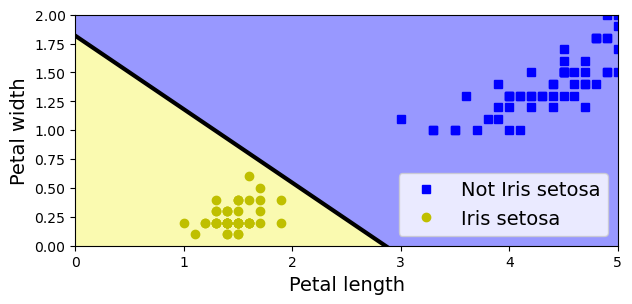

In [21]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

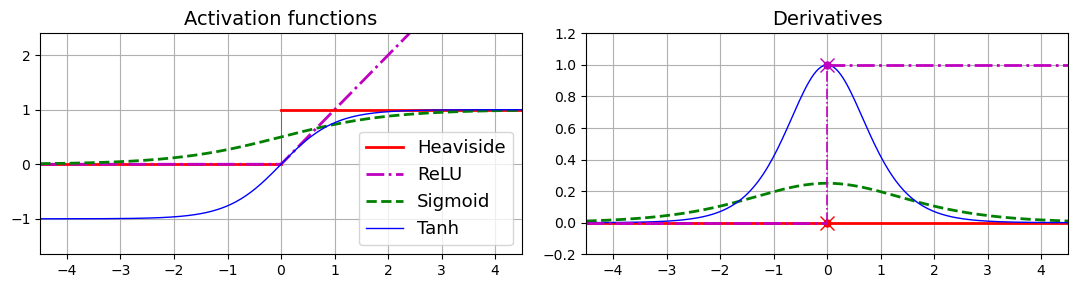

In [23]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [25]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
rmse

0.5053326657968762

## Classification MLPs

In [28]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [31]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [33]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [35]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [37]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

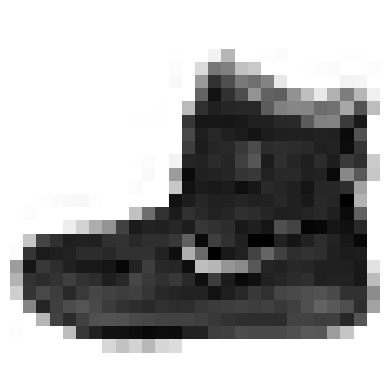

In [39]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [41]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [43]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [45]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

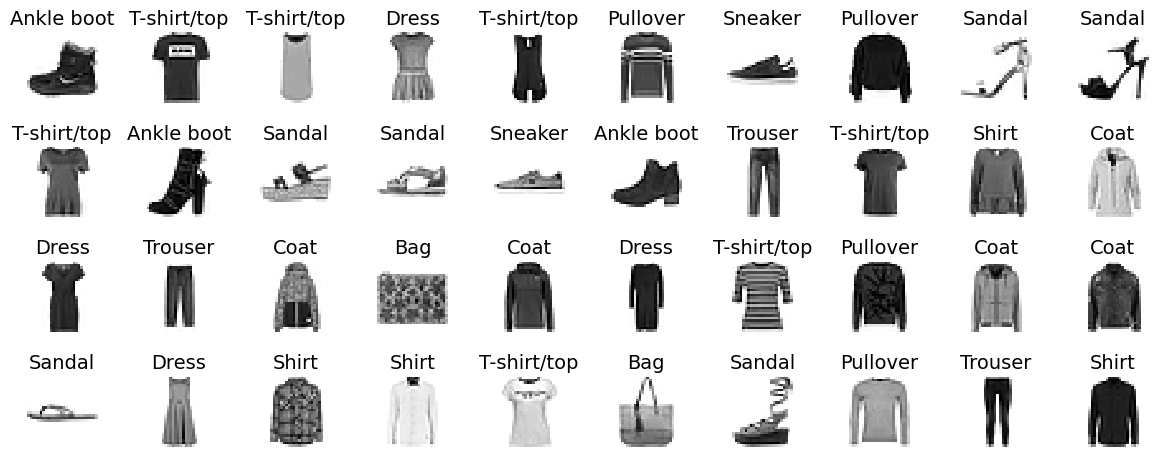

In [47]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [49]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [50]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [53]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [54]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [55]:
model.get_layer('dense') is hidden1

True

In [56]:
weights, biases = hidden1.get_weights()
weights

array([[-0.07274868,  0.05608925, -0.00736359, ..., -0.00659209,
         0.03294125, -0.0275479 ],
       [-0.03837393,  0.0013109 ,  0.06830136, ..., -0.04141796,
         0.06460582,  0.07338928],
       [ 0.03756436, -0.04376955,  0.04410381, ...,  0.0131899 ,
        -0.05050345,  0.06706508],
       ...,
       [-0.07418615, -0.03143774, -0.05529467, ..., -0.04992002,
        -0.07313164, -0.00303626],
       [-0.06749322,  0.01493153, -0.07140888, ...,  0.03077944,
        -0.06551469,  0.06322829],
       [ 0.04265283,  0.07260689,  0.00129186, ...,  0.05921403,
        -0.039838  , -0.06327568]], dtype=float32)

In [57]:
weights.shape

(784, 300)

In [58]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [59]:
biases.shape

(300,)

### Compiling the model

In [61]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [63]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [64]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [66]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [68]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - loss: 0.9880 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.5077 - val_sparse_categorical_accuracy: 0.8292
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - loss: 0.5092 - sparse_categorical_accuracy: 0.8242 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.8420
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - loss: 0.4546 - sparse_categorical_accuracy: 0.8428 - val_loss: 0.4241 - val_sparse_categorical_accuracy: 0.8462
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 0.4234 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.8534
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.4008 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.8558
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - loss: 0.3834 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.3842 - val_sparse_categoric

In [69]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [70]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


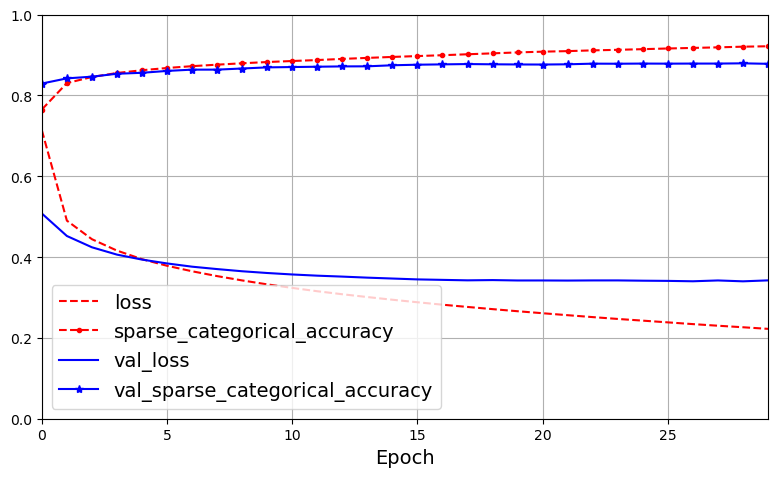

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

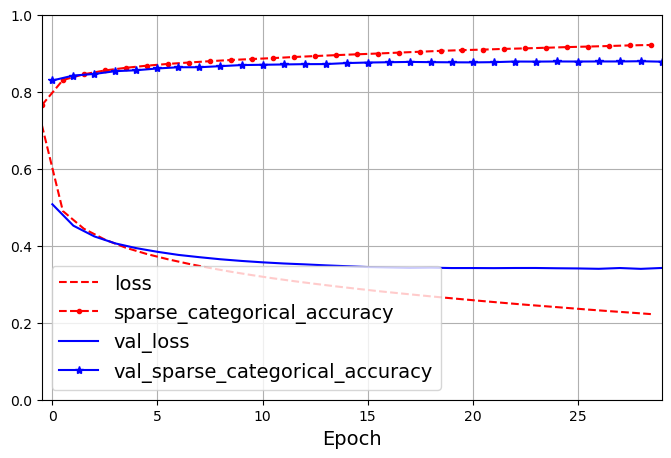

In [72]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [73]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.3642 - sparse_categorical_accuracy: 0.8783


[0.36366501450538635, 0.8758999705314636]

### Using the model to make predictions

In [75]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.01, 0.  , 0.78],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [76]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [77]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [78]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

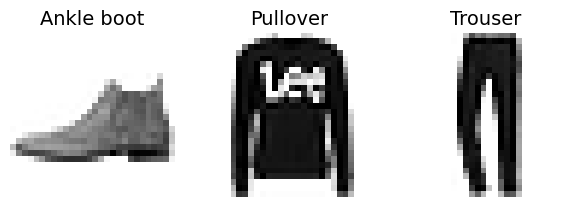

In [79]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [82]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [83]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - RootMeanSquaredError: 1.1860 - loss: 1.5125 - val_RootMeanSquaredError: 0.7312 - val_loss: 0.5347
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.6250 - loss: 0.3909 - val_RootMeanSquaredError: 1.2256 - val_loss: 1.5022
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - RootMeanSquaredError: 0.6023 - loss: 0.3630 - val_RootMeanSquaredError: 1.2358 - val_loss: 1.5272
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - RootMeanSquaredError: 0.5924 - loss: 0.3511 - val_RootMeanSquaredError: 1.1812 - val_loss: 1.3952
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - RootMeanSquaredError: 0.5829 - loss: 0.3399 - val_RootMeanSquaredError: 1.2651 - val_loss: 1.6005
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.5790 - loss: 0.3353 - val_RootMeanSquaredError: 1.1346 - val_loss: 1.2874
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.5708 - 

In [84]:
rmse_test

0.5307629704475403

In [85]:
y_pred

array([[0.564329 ],
       [1.3368657],
       [4.835432 ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [88]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [89]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [90]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [91]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - RootMeanSquaredError: 1.3802 - loss: 1.9920 - val_RootMeanSquaredError: 0.8638 - val_loss: 0.7462
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - RootMeanSquaredError: 0.7367 - loss: 0.5449 - val_RootMeanSquaredError: 0.9792 - val_loss: 0.9588
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - RootMeanSquaredError: 0.6480 - loss: 0.4204 - val_RootMeanSquaredError: 1.0926 - val_loss: 1.1939
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - RootMeanSquaredError: 0.6215 - loss: 0.3864 - val_RootMeanSquaredError: 1.2199 - val_loss: 1.4883
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - RootMeanSquaredError: 0.6061 - loss: 0.3675 - val_RootMeanSquaredError: 1.3229 - val_loss: 1.7500
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - RootMeanSquaredError: 0.5972 - loss: 0.3568 - val_RootMeanSquaredError: 1.2742 - val_loss: 1.6235
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - RootMeanSquaredError: 0.5900 - 

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [93]:
tf.random.set_seed(42)  # extra code

In [94]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_6', 'keras_tensor_7']. Received: the structure of inputs=('*', '*')
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - RootMeanSquaredError: 1.4333 - loss: 2.1309 - val_RootMeanSquaredError: 0.8662 - val_loss: 0.7503
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - RootMeanSquaredError: 0.7321 - loss: 0.5365 - val_RootMeanSquaredError: 0.6704 - val_loss: 0.4495
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - RootMeanSquaredError: 0.6803 - loss: 0.4630 - val_RootMeanSquaredError: 0.6713 - val_loss: 0.4507
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - RootMeanSquaredError: 0.6604 - loss: 0.4364 - val_RootMeanSquaredError: 0.6733 - val_loss: 0.4533
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - RootMeanSquaredError: 0.6469 - loss: 0.4187 - val_RootMeanSquaredError: 0.8899 - val_loss: 0.7920
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - RootMeanSquaredError: 0.6394 - loss: 0.4090 - val_RootMeanSquaredError: 1.1039 - val_loss: 1.2186
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - RootMeanSquaredError: 0.6318 - 

Adding an auxiliary output for regularization:

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [98]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

**Warning**: in recent versions, Keras requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [100]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

## Using the Subclassing API to Build Dynamic Models

In [102]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Warning**: as explained above, Keras now requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [104]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - RootMeanSquaredError: 1.5622 - RootMeanSquaredError_1: 1.6990 - loss: 2.6082 - mse_loss: 0.2966 - val_RootMeanSquaredError: 0.8933 - val_RootMeanSquaredError_1: 1.0908 - val_loss: 0.8371 - val_mse_loss: 0.1190
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - RootMeanSquaredError: 0.7306 - RootMeanSquaredError_1: 0.9342 - loss: 0.5684 - mse_loss: 0.0874 - val_RootMeanSquaredError: 0.6601 - val_RootMeanSquaredError_1: 0.9162 - val_loss: 0.4761 - val_mse_loss: 0.0839
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - RootMeanSquaredError: 0.6664 - RootMeanSquaredError_1: 0.8053 - loss: 0.4648 - mse_loss: 0.0649 - val_RootMeanSquaredError: 0.6272 - val_RootMeanSquaredError_1: 0.8217 - val_loss: 0.4216 - val_mse_loss: 0.0675
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - RootMeanSquaredError: 0.6429 - RootMeanSquaredError_1: 0.7633 - loss: 0.4304 - mse_loss: 0.0583 - val_RootMeanSquaredError: 0.6010 - val_RootMeanS

## Saving and Restoring a Model

**Warning**: Keras now recommends using the `.keras` format to save models, and the `h5` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's `SavedModel` format, and then how you can use the recommended formats.

In [107]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Warning**: Keras's `model.save()` method no longer supports TensorFlow's `SavedModel` format. However, you can still export models to the `SavedModel` format using `model.export()` like this:

In [109]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  14132616208: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  14132620624: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  14132618512: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  14132618320: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  13455624336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13455635472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13111061264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13111061456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13111056272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [110]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


**Warning**: In Keras 3, it is no longer possible to load a TensorFlow `SavedModel` as a Keras model. However, you can load a `SavedModel` as a `tf.keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [112]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

**Warning**: Keras now requires the saved weights to have the `.weights.h5` extension. There are no longer saved using the `SavedModel` format.

In [114]:
model.save_weights("my_weights.weights.h5")

In [115]:
model.load_weights("my_weights.weights.h5")

To save a model using the `.keras` format, simply use `model.save()`:

In [117]:
model.save("my_model.keras")

To load a `.keras` model, use the `tf.keras.models.load_model()` function. If the model uses any custom object, you must pass them to the function via the `custom_objects` argument:

In [119]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

## Using Callbacks

In [121]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

**Warning**: as explained earlier, Keras now requires the checkpoint files to have a `.weights.h5` extension:

In [123]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - RootMeanSquaredError: 0.5941 - RootMeanSquaredError_1: 0.6686 - loss: 0.3624 - mse_loss: 0.0447 - val_RootMeanSquaredError: 1.8398 - val_RootMeanSquaredError_1: 1.8798 - val_loss: 3.3997 - val_mse_loss: 0.3532
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - RootMeanSquaredError: 0.5943 - RootMeanSquaredError_1: 0.6607 - loss: 0.3617 - mse_loss: 0.0437 - val_RootMeanSquaredError: 1.1808 - val_RootMeanSquaredError_1: 0.8694 - val_loss: 1.3304 - val_mse_loss: 0.0756
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - RootMeanSquaredError: 0.5854 - RootMeanSquaredError_1: 0.6473 - loss: 0.3504 - mse_loss: 0.0419 - val_RootMeanSquaredError: 1.1015 - val_RootMeanSquaredError_1: 1.1501 - val_loss: 1.2243 - val_mse_loss: 0.1322
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - RootMeanSquaredError: 0.5826 - RootMeanSquaredError_1: 0.6431 - loss: 0.3469 - mse_loss: 0.0414 - val_RootMeanSquaredError: 1.2749 - val_RootMeanS

In [124]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - RootMeanSquaredError: 0.5736 - RootMeanSquaredError_1: 0.6241 - loss: 0.3351 - mse_loss: 0.0390 - val_RootMeanSquaredError: 1.0793 - val_RootMeanSquaredError_1: 1.3304 - val_loss: 1.2255 - val_mse_loss: 0.1769
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - RootMeanSquaredError: 0.5711 - RootMeanSquaredError_1: 0.6212 - loss: 0.3322 - mse_loss: 0.0386 - val_RootMeanSquaredError: 0.8843 - val_RootMeanSquaredError_1: 0.8305 - val_loss: 0.7728 - val_mse_loss: 0.0690
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - RootMeanSquaredError: 0.5698 - RootMeanSquaredError_1: 0.6216 - loss: 0.3309 - mse_loss: 0.0386 - val_RootMeanSquaredError: 1.0132 - val_RootMeanSquaredError_1: 1.3035 - val_loss: 1.0938 - val_mse_loss: 0.1698
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - RootMeanSquaredError: 0.5693 - RootMeanSquaredError_1: 0.6187 - loss: 0.3300 - mse_loss: 0.0383 - val_RootMeanSquaredError: 0.9119 - val_RootM

In [125]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [126]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=2.23
Epoch=1, val/train=1.55
Epoch=2, val/train=4.41
Epoch=3, val/train=2.46
Epoch=4, val/train=2.99
Epoch=5, val/train=1.41
Epoch=6, val/train=1.86
Epoch=7, val/train=1.15
Epoch=8, val/train=1.69
Epoch=9, val/train=1.23


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [129]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [130]:
shutil.rmtree("my_logs", ignore_errors=True)

In [131]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [132]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2024-11-04 21:17:55.089655: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-04 21:17:55.089664: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-04 21:17:55.089685: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - RootMeanSquaredError: 1.7729 - loss: 3.2214 - val_RootMeanSquaredError: 0.9351 - val_loss: 0.8745
Epoch 2/20
193/363 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - RootMeanSquaredError: 0.9380 - loss: 0.8806

2024-11-04 21:17:55.310759: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-04 21:17:55.310772: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-04 21:17:55.337518: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-11-04 21:17:55.342794: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-11-04 21:17:55.344757: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_11_04_21_17_54/plugins/profile/2024_11_04_21_17_55/Mac.lan.xplane.pb


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - RootMeanSquaredError: 0.9078 - loss: 0.8255 - val_RootMeanSquaredError: 0.7875 - val_loss: 0.6202
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - RootMeanSquaredError: 0.8178 - loss: 0.6696 - val_RootMeanSquaredError: 0.7436 - val_loss: 0.5529
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.7843 - loss: 0.6161 - val_RootMeanSquaredError: 0.7189 - val_loss: 0.5168
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - RootMeanSquaredError: 0.7610 - loss: 0.5800 - val_RootMeanSquaredError: 0.7007 - val_loss: 0.4910
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.7427 - loss: 0.5523 - val_RootMeanSquaredError: 0.6867 - val_loss: 0.4715
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - RootMeanSquaredError: 0.7279 - loss: 0.5306 - val_RootMeanSquaredError: 0.6758 - val_loss: 0.4566
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - RootMeanSquaredError: 0.7157 - 

In [134]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_11_04_21_17_54
    plugins
      profile
        2024_11_04_21_17_55
          Mac.lan.xplane.pb
    train
      events.out.tfevents.1730751475.Mac.lan.68078.0.v2
    validation
      events.out.tfevents.1730751475.Mac.lan.68078.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [136]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

Reusing TensorBoard on port 6010 (pid 56881), started 1 day, 7:09:38 ago. (Use '!kill 56881' to kill it.)

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [138]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [140]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [143]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6012: logdir ./my_mnist_logs (started 1 day, 7:02:53 ago; pid 57079)
  - port 6013: logdir logs/fit (started 1 day, 6:56:40 ago; pid 57239)
  - port 6010: logdir ./my_logs (started 1 day, 7:09:42 ago; pid 56881)
  - port 6011: logdir my_fashion_mnist/hyperband/tensorboard (started 1 day, 7:03:22 ago; pid 57072)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [147]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [148]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [149]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [150]:
!pip install keras_tuner==1.4.6

In [151]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [152]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 06s]
val_accuracy: 0.8331999778747559

Best val_accuracy So Far: 0.8514000177383423
Total elapsed time: 00h 00m 34s


In [153]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [154]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [155]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8514000177383423


In [156]:
best_trial.metrics.get_last_value("val_accuracy")

0.8514000177383423

In [157]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.8773 - loss: 0.3302
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.8827 - loss: 0.3182
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - accuracy: 0.8867 - loss: 0.3075
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.8902 - loss: 0.2974
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.8927 - loss: 0.2894
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.8961 - loss: 0.2816
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.8989 - loss: 0.2749
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.9014 - loss: 0.2687
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.9026 - loss: 0.2627
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.9049 - loss: 0.2573
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.8562 - loss: 0.4197


In [158]:
%tensorboard --logdir {root_logdir}

# Exercise solutions

## 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [166]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [168]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [170]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [172]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

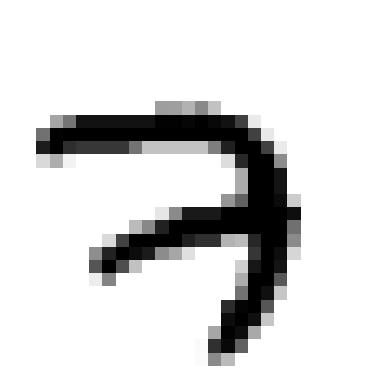

In [174]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [176]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [178]:
X_valid.shape

(5000, 28, 28)

In [179]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

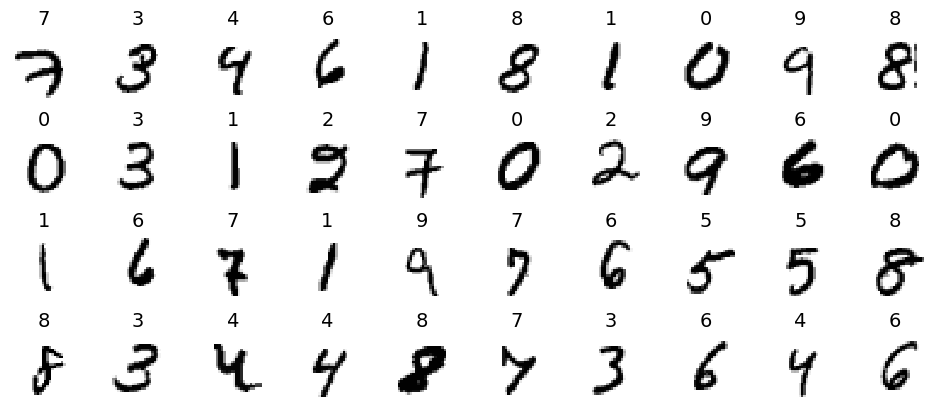

In [181]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [183]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [184]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [185]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [187]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [189]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.5097 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

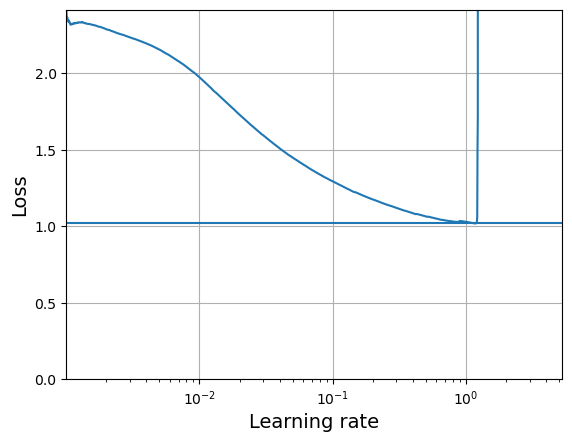

In [191]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [193]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [194]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [195]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [196]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [197]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.8678 - loss: 0.4116 - val_accuracy: 0.9702 - val_loss: 0.1046
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.9688 - loss: 0.1015 - val_accuracy: 0.9746 - val_loss: 0.0856
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.9808 - loss: 0.0609 - val_accuracy: 0.9714 - val_loss: 0.1114
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.9868 - loss: 0.0456 - val_accuracy: 0.9750 - val_loss: 0.0908
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.9893 - loss: 0.0335 - val_accuracy: 0.9762 - val_loss: 0.0958
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.9916 - loss: 0.0257 - val_accuracy: 0.9778 - val_loss: 0.0948
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.9927 - loss: 0.0230 - val_accuracy: 0.9710 - val_loss: 0.1515
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 

In [198]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.9706 - loss: 0.0916


[0.0758734941482544, 0.9750000238418579]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [200]:
%tensorboard --logdir=./my_mnist_logs

Reusing TensorBoard on port 6012 (pid 57079), started 1 day, 7:04:04 ago. (Use '!kill 57079' to kill it.)

# Hyperparameter Tuning of a Deep MLP

In [346]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    n_hidden = hp.Int("n_hidden", min_value=1, max_value=2)
    batch_size = hp.Int("batch_size", 32, 128, step=32, default=64)

    for _ in range(n_hidden):
        n_neurons = hp.Int("n_neurons", min_value=32, max_value=64, step=32)
        model.add(layers.Dense(n_neurons, activation="relu", 
                               kernel_regularizer=regularizers.l2(0.005)))
        model.add(layers.Dropout(hp.Float("dropout", min_value=0.5, max_value=0.7, step=0.1)))

    model.add(layers.Dense(10, activation="softmax"))

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

In [348]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=2,
    directory="my_dir",
    project_name="mnist_tuning"
)

Reloading Tuner from my_dir/mnist_tuning/tuner0.json


In [350]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [352]:
tuner.search(
    X_train, 
    y_train, 
    epochs=50, 
    validation_split=0.2,  
    callbacks=[early_stopping, lr_scheduler]
)

In [354]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]  
)

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9808 - val_loss: 0.1377
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.9794 - val_loss: 0.1314
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9818 - val_loss: 0.1245
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9804 - val_loss: 0.1332
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9808 - val_loss: 0.1373
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9804 - val_loss: 0.1418
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9814 - val_loss: 0.1263
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9980 -

In [372]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of hidden layers is {best_hps.get('n_hidden')}.
The optimal number of neurons per layer is {best_hps.get('n_neurons')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal batch size is {best_hps.get('batch_size')}.
""")


The optimal number of hidden layers is 2.
The optimal number of neurons per layer is 128.
The optimal dropout rate is 0.311717276467766.
The optimal learning rate is 0.0003849638422450448.
The optimal batch size is 64.



In [364]:
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - accuracy: 0.9780 - loss: 0.3605
Test accuracy: 0.9818999767303467


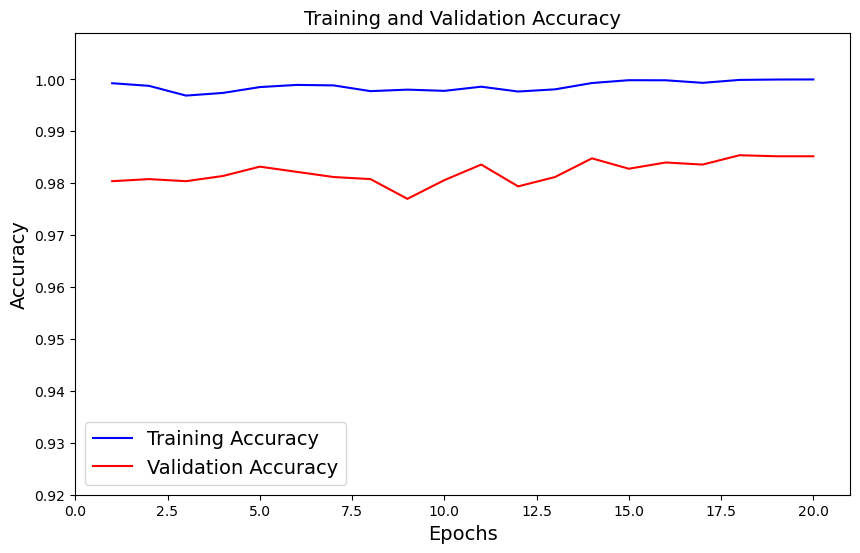

In [398]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, len(train_acc) + 1, 0.92, 1.009])
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [370]:
import time

# Before training
start_time = time.time()

# Training process
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb]  
)

# After training
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9804 - val_loss: 0.1332
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9808 - val_loss: 0.1373
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9804 - val_loss: 0.1418
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9814 - val_loss: 0.1263
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9832 - val_loss: 0.1271
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9822 - val_loss: 0.1275
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9812 - val_loss: 0.1277
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.9980 -

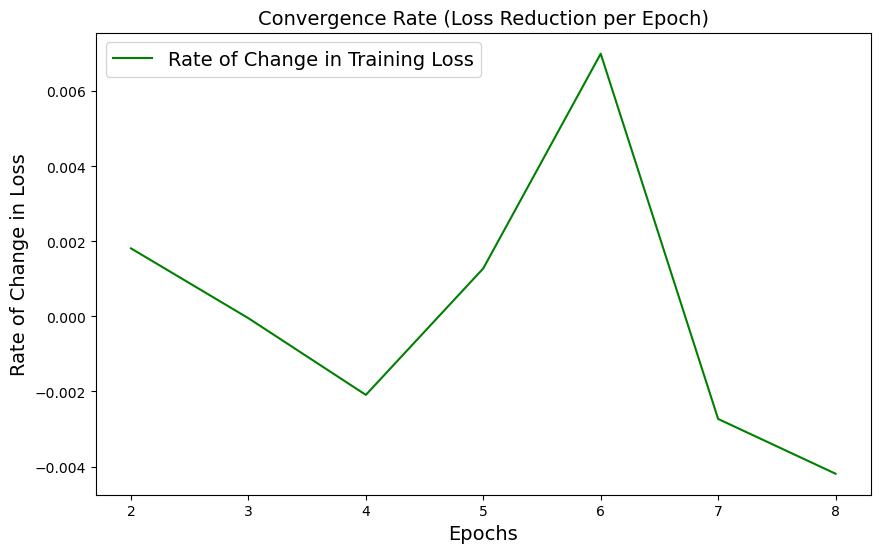

In [371]:
import numpy as np

# Calculate the rate of change in loss
rate_of_change = np.diff(train_loss)  # Derivative of training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[1:], rate_of_change, 'g-', label='Rate of Change in Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Rate of Change in Loss')
plt.title('Convergence Rate (Loss Reduction per Epoch)')
plt.legend()
plt.show()
